In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

np.random.seed(1234)

In [21]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

Using device: cuda
NVIDIA GeForce GTX 1650


In [22]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [63]:
class PINN():
    def __init__(self, X, Y, masks, layers, h, l, r, nu):
        self.x = torch.tensor(X, requires_grad=True).float().to(device).view(-1, 1)
        self.y = torch.tensor(Y, requires_grad=True).float().to(device).view(-1, 1)
        self.data = torch.cat((self.x, self.y), dim=1)

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_down = masks['down']
        self.mask_hole = masks['hole']

        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.w_pde = 1
        self.w_bc = 1
        self.lr_adam = 0.005
        self.lr_lbfgs = 0.005

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=5000,
            max_eval=5000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=self.lr_adam)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, data):
        out = self.dnn(data)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(self, u, v, sxx, syy, sxy, data):

        du = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True)[0]
        dx_u = du[:, 0:1]
        dy_u = du[:, 1:2]

        dv = torch.autograd.grad(v, data, torch.ones_like(v), create_graph=True)[0]
        dx_v = dv[:, 0:1]
        dy_v = dv[:, 1:2]

        dx_sxx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dy_syy = torch.autograd.grad(syy, data, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        dsxy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = dsxy[:, 0:1]
        dy_sxy = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, u, v, sxx, syy, sxy, data):

        b = torch.mean(torch.pow(u[self.mask_left], 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        b += torch.mean(torch.pow(syy[self.mask_down], 2))
        b += torch.mean(torch.pow(sxy[self.mask_down], 2))

        x = data[:, 0:1]
        y = data[:, 1:2]
        nx = -(x[self.mask_hole]-self.l/2)/self.r
        ny = -(y[self.mask_hole]-self.h/2)/self.r
        tx = torch.mul(sxx[self.mask_hole], nx) + torch.mul(sxy[self.mask_hole], ny)
        ty = torch.mul(sxy[self.mask_hole], nx) + torch.mul(syy[self.mask_hole], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self):
        u, v, sxx, syy, sxy = self.model_value(self.data)
        pde = self.pde_loss(u, v, sxx, syy, sxy, self.data)
        bc = self.bc_loss(u, v, sxx, syy, sxy, self.data)
        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)
        data = torch.cat((x, y), dim=1)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(data)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [64]:
def generate_points(pd, pb, l, h, r):
    a = l / 2
    b = h / 2

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new)
    mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    dom = dom[mask]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = (lhs(1, pb) * h).flatten()


    top_x = (lhs(1, pb) * l).flatten()
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = (lhs(1, pb) * h).flatten()

    down_x = (lhs(1, pb) * l).flatten()
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, 2*np.pi, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    rad = np.sqrt((hole_x*l - l/2)**2 + (hole_y*h - h/2)**2)

    dom_x = np.hstack((dom_x, hole_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole_y, left_y, top_y, right_y, down_y))

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x, 'hole': hole_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y, 'hole': hole_y}
    return X, Y

In [65]:
l = 1
h = 1
r = 0.1
E = 1
nu = 0.3


X, Y = generate_points(10000, 500, l, h, r)

nodes = 128
layers = [2] + 4 * [nodes] + [5]

In [66]:

dom_x = X['dom']
dom_y = Y['dom']

mask_left = np.equal(dom_x, 0)
mask_top = np.equal(dom_y, h)
mask_right = np.equal(dom_x, l)
mask_down = np.equal(dom_y, 0)
rad = np.sqrt((dom_x*l - l/2)**2 + (dom_y*h - h/2)**2)
mask_hole = np.isclose(rad, r)

print(dom_x[mask_hole].shape)

masks = {
    'left': mask_left,
    'top': mask_top,
    'right': mask_right, 
    'down': mask_down,
    'hole': mask_hole
}


(500,)


In [67]:
model = PINN(dom_x, dom_y, masks, layers, h, l, r, nu)

In [68]:
print(model.dnn)

DNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=5, bias=True)
  )
)


In [69]:
model.train(5000)

Epoch 0, Loss: 1.261995e+00
PDE: 2.030645e-01, BC: 1.058930e+00
Epoch 100, Loss: 2.950219e-01
PDE: 2.609892e-02, BC: 2.689230e-01
Epoch 200, Loss: 2.936094e-01
PDE: 2.536037e-02, BC: 2.682491e-01
Epoch 300, Loss: 2.923065e-01
PDE: 2.503589e-02, BC: 2.672706e-01
Epoch 400, Loss: 2.891683e-01
PDE: 2.441134e-02, BC: 2.647570e-01
Epoch 500, Loss: 2.962499e-01
PDE: 2.708977e-02, BC: 2.691601e-01
Epoch 600, Loss: 2.931544e-01
PDE: 2.526121e-02, BC: 2.678931e-01
Epoch 700, Loss: 2.911901e-01
PDE: 2.484803e-02, BC: 2.663421e-01
Epoch 800, Loss: 2.704754e-01
PDE: 3.528221e-02, BC: 2.351932e-01
Epoch 900, Loss: 2.610499e-01
PDE: 3.371222e-02, BC: 2.273377e-01
Epoch 1000, Loss: 2.591712e-01
PDE: 3.327761e-02, BC: 2.258936e-01
Epoch 1100, Loss: 2.151275e-01
PDE: 3.406560e-02, BC: 1.810619e-01
Epoch 1200, Loss: 2.070029e-01
PDE: 5.026011e-02, BC: 1.567428e-01
Epoch 1300, Loss: 1.407447e-01
PDE: 6.338528e-02, BC: 7.735948e-02
Epoch 1400, Loss: 2.239643e-01
PDE: 1.814897e-01, BC: 4.247461e-02
Epoch 1

In [70]:
x_p = 100
y_p = 100

x = np.linspace(0, l, x_p)
y = np.linspace(0, h, y_p)
X, Y = np.meshgrid(x, y)

points = np.vstack((X.ravel(), Y.ravel())).T

distances = np.sqrt((points[:, 0] - l/2)**2 + (points[:, 1] - h/2)**2)
filtered_points = points[distances > r]

# plt.figure(figsize=(8, 4))
# plt.scatter(filtered_points[:, 0], filtered_points[:, 1], s=1)
# circle = plt.Circle((l/2, h/2), r, color='r', fill=False)
# plt.gca().add_patch(circle)

# plt.xlim(0, l)
# plt.ylim(0, h)
# plt.gca().set_aspect('equal')
# plt.title("Grid of Points in Rectangular Domain with Circular Hole")
# plt.show()

x_pred = filtered_points[:, 0].reshape(-1, 1)
y_pred = filtered_points[:, 1].reshape(-1, 1)

x = torch.tensor(x_pred).float().to(device)
y = torch.tensor(y_pred).float().to(device)
data = torch.cat((x, y), dim=1)

u, v, sxx, syy, sxy = model.model_value(data)

In [71]:
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
sxx = sxx.detach().cpu().numpy()
syy = syy.detach().cpu().numpy()
sxy = sxy.detach().cpu().numpy()

In [72]:
L = 1  # Length of the sheet
H = 1   # Height of the sheet
nx, ny = 10, 10  # Number of grid points in x and y
E = 7e10  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u1 = u*U
v1 = v*U
sxx1 = sxx*sigma_0
syy1 = syy*sigma_0
sxy1 = sxy*sigma_0


In [73]:
von_mises = np.sqrt(sxx1**2 + syy1**2 - sxx1*syy1 + 3*sxy1**2)
print(von_mises)

[[59960180.]
 [59612948.]
 [59286048.]
 ...
 [48640588.]
 [48633944.]
 [48630452.]]


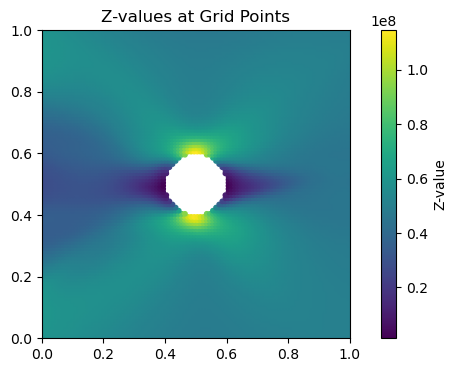

In [74]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x_pred, y_pred, c=von_mises, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")
plt.xlim(0, l)
plt.ylim(0, h)
plt.gca().set_aspect('equal')
plt.show()